In [1]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [12]:
#(hardware name, number of nodes, plotstyle)
filesCPUs = {
         'knl_mpi1':('knl',1), 'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
         'skl_mpi1':('skl',1), 'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
         'i5':('i5',1)}
filesGPUs = {
         'p100_mpi1':('p100',1), 'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
         'v100_mpi1':('v100',1), 'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
         'gtx1060':('gtx1060',1,)
             }
# order by number of nodes to make labeling easier further down
cpuFiles = odict(sorted(filesCPUs.items(), key= lambda t : t[1][1]))
gpuFiles = odict(sorted(filesGPUs.items(), key= lambda t : t[1][1]))
# count number of 1 nodes in dict
number=0
for k,v in cpuFiles.items(): 
    if v[1]==1: number+=1
        
arch = {'knl':(cm.Greens,450,0.5,0.33),'skl':(cm.Greys,200,0.5,0.75),'p100':(cm.Blues,550,0.5,0.43),
        'v100':(cm.Purples,850,0.5,0.85),'i5':(cm.Wistia,30,0.5,0.79),'gtx1060':(cm.Oranges,155,0.5,0.70)}
intens={1:0.8, 2:0.6, 4:0.4}
marker={2:'d', 3:'o', 4:'s',5:'p'}

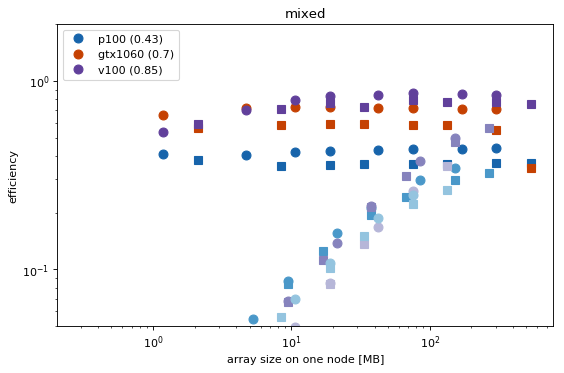

In [14]:
ns=[3,4]
for q in ['mixed'] : #,'dx','dy']:
    fig,ax=plt.subplots(1,1,figsize=(8,5),dpi= 80, facecolor='w', edgecolor='k')
    for f, v in gpuFiles.items():  
        #read in csv file
        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        bw = df[['n','Nx','Ny','size']]
        bw = bw.assign(dx = df['size']/1000*3/df['dx']/arch[v[0]][1])
        bw = bw.assign(dy = df['size']/1000*3/df['dy']/arch[v[0]][1])
        bw = bw.assign(mixed=2.0*bw['dx']*bw['dy']/(bw['dx']+bw['dy']))
        #compute mean and standard derivation of 'same' groups 
        bw=bw.groupby(['n', 'Nx','Ny','size']).agg(['mean', 'std'])
        bw=bw.reset_index(level=['Nx','Ny','size'])
        for n in ns:
            bw.loc[n][q].plot(ax=ax,color=arch[v[0]][0](intens[v[1]]), marker=marker[n],ls='',
                    x=bw.loc[n,'size'],y='mean',label=v[0]+' ('+str(arch[v[0]][3])+')', markersize=8)
    plt.xlabel('array size on one node [MB]')
    plt.ylabel('efficiency')
    plt.xscale('log')
    plt.yscale('log')
    #for k,v in arch.items():
    #    if q=='mixed' : 
    #        plt.axhline(y=v[3],xmin=v[2],xmax=1,color=v[0](1.0),lw=2)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:len(ns)*number:len(ns)]; labels = labels[0:len(ns)*number:len(ns)]
    plt.legend(handles, labels, loc='upper left',numpoints=1)
    plt.title(q)
    plt.ylim(5e-2,2)
    #plt.xlim(10,1000)
    

#### Conclusions
- efficiency of derivatives difficult to determine for skl and knl
- depends on n 
- maybe compute average efficiency for 10+ MB ?
- extremely high latencies for NVidia GPUs make MPI + GPU unusable
- also for KNL the latencies in MPI seem very high
